In [18]:
import minio
import os
import cv2 as cv
import matplotlib.pyplot as plt

minio_client = minio.Minio(
    os.environ['MINIO_ENDPOINT'],
    access_key=os.environ['MINIO_ACCESS_KEY'],
    secret_key=os.environ['MINIO_SECRET_KEY'],
    secure=False
)

In [ ]:
bucket = 'highjump'
path = 'raw_data/2025/03/14/run6/'
download_path = 'data/videos/'

video_list = list(minio_client.list_objects(bucket, path))

for video in video_list:
    minio_client.fget_object(bucket, video.object_name, download_path + video.object_name.split('/')[-1])

In [27]:
class MultiCam:
    def __init__(self, video_list):
        self.video_list = video_list
        self.cap_list: list[cv.VideoCapture] = []
        for video in video_list:
            self.cap_list.append(cv.VideoCapture(video))

    def seek(self, frame):
        for cap in self.cap_list:
            cap.set(cv.CAP_PROP_POS_FRAMES, frame)

    def get_frame(self):
        frame_list = []
        for cap in self.cap_list:
            ret, frame = cap.read()
            frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
            frame_list.append(frame)
        return frame_list

    def release(self):
        for cap in self.cap_list:
            cap.release()

multi_cam = MultiCam([download_path + 'sidecam.mp4', download_path + 'curve_cam.mp4', download_path + 'centercam.mp4'])

In [28]:
multi_cam.seek(1000)
frame_list = multi_cam.get_frame()

In [31]:
def plot_frame(frame_list):
    fig, axs = plt.subplots(3,1, figsize=(15, 5))
    for i, frame in enumerate(frame_list):
        axs[i].imshow(frame)
    plt.show()

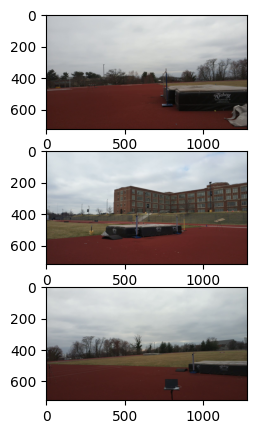

In [32]:
plot_frame(frame_list)